
<a href="https://colab.research.google.com/github/Argentan/DMA_LAB2/blob/master/tutoriales/04_preprocesamiento_sklearn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scikit Learn

Desde hace años, Scikit Learn es el estándar de facto en términos de paquetes de utilidades y algoritmos de aprendizaje automático. Si bien en los últimos tiempos, tanto en gradient boosting como en deep learning, han surgido otros paquetes que son más populares en determinados contextos, esta librería sigue teniendo toda la funcionalidad de soporte para desarrollar y automatizar procesos de entrenamiento y predicción.

Iremos viendo este paquete de una manera funcional, a través de las tareas propias de un proceso de desarrollo e implementación de aprendizaje automático.

#### *Nota sobre la API de sklearn*: la gran mayoría de algoritmos y utilidades son clases que se instancia llamándola como una función con parámetro de inicialización y luego tiene dos métodos, `fit` para entrenar el algoritmo y `transform` o `predict` para aplicarlo, según el caso y la utilidad. Existen algunas funciones simples también para funcionalidades más sencillas. 

## 1. Pre-procesado

Luego de la lectura de datos que ya vimos con `Pandas`, la primera tarea de manipulación de datos suele ser el preprocesador, que consiste en la transformación de los datos para que sean procesables y/o más compatibles con el algoritmo elegido o incluso que le permitan más poder explicativo.

Las transformaciones para lograr que -algunos algoritmos- puedan procesar los datos son la `asignación de nulos` y, en menor medida, la `codificación de variables no intervalares (categóricas y ordinales) `; mientras que el `escalado y normalización` tiende a lograr una mejor compatibilidad con ciertos modelos. Por otro lado, la creación de variables, aunque contiene una gran parte de arte, es una forma muy potente de agregar poder explicativo al modelo.

Veremos estas técnicas en el orden lógico de su utilización, aunque algunas, particularmente las que operan sobre columnas independientes como el escalado y la codificación, son intercambiables.

Asimismo, existen algunas técnicas como la discretización (bins) o la transformación binaria que ya no se usan a menudo; al igual que técnicas de detección de valores extremos (`outliers`) y reducción de dimensionalidad que no tienen ya los mismos beneficios que en otras épocas con menos capacidad de cálculo y algoritmos menos sofisticados. 

### A.- Asignación de nulos o perdidos

Excepto alguna implementación de `gradient boosting`, **todos** los algoritmos de aprendizaje automático son incompatibles con la existencia de nulos en el dataset. 

Con los valores perdidos hay que ser especialmente cuidadoso, porque a veces tienen de por sí un sentido, es decir que no son al azar. Si es así, hay que buscar una forma lógica de completarlos. Si no, se pueden completar de alguna forma distinta.

In [53]:
import numpy as np
import pandas as pd
X = pd.DataFrame([
    [1,2,3,np.nan],
    [np.nan, np.nan, np.nan, 0],
    [-5, 0, 25, np.nan],
    [1,-1, np.nan, np.nan]
], columns=[f"c{i}" for i in range(4)])
X

,c0,c1,c2,c3
0,1.0,2.0,3.0,NaN
1,NaN,NaN,NaN,0.0
2,-5.0,0.0,25.0,NaN
3,1.0,-1.0,NaN,NaN


Podemos eliminar filas o columnas completas cuando posean muchos nulos usando `dropna`.

Con `axis` definimos si se aplica sobre filas o columnas.

Con `thresh`, se puede definir a partir de cuántos nulos consideramos que debe borrarse (inicia en 0).

In [54]:
X.dropna(axis=0, thresh=2)

,c0,c1,c2,c3
0,1.0,2.0,3.0,NaN
2,-5.0,0.0,25.0,NaN
3,1.0,-1.0,NaN,NaN


Con `axis = 1` eliminamos por columna en lugar de fila

In [55]:
X.dropna(axis=1, thresh=2)

,c0,c1,c2
0,1.0,2.0,3.0
1,NaN,NaN,NaN
2,-5.0,0.0,25.0
3,1.0,-1.0,NaN


Con `fillna` podemos completar con algún valor constante.

Es recomendable utilizar algún valor fuera del rango de valores de la variable para que se identifique claramente que era perdido.

In [56]:
X.fillna(999)

,c0,c1,c2,c3
0,1.0,2.0,3.0,999.0
1,999.0,999.0,999.0,0.0
2,-5.0,0.0,25.0,999.0
3,1.0,-1.0,999.0,999.0


Con `SimpleImputer` podemos remplazarlo usando una función de agregación, como por ejemplo:


*   mean: media
*   median: mediana
*   most_frequent: valor más frecuente
*   constant: un valor constante




In [57]:
X

,c0,c1,c2,c3
0,1.0,2.0,3.0,NaN
1,NaN,NaN,NaN,0.0
2,-5.0,0.0,25.0,NaN
3,1.0,-1.0,NaN,NaN


In [58]:
from sklearn.impute import SimpleImputer

#media
SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X)

array([[ 1.        ,  2.        ,  3.        ,  0.        ],
       [-1.        ,  0.33333333, 14.        ,  0.        ],
       [-5.        ,  0.        , 25.        ,  0.        ],
       [ 1.        , -1.        , 14.        ,  0.        ]])

In [59]:
#valor más frecuente
SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(X)

array([[ 1.,  2.,  3.,  0.],
       [ 1., -1.,  3.,  0.],
       [-5.,  0., 25.,  0.],
       [ 1., -1.,  3.,  0.]])

Con `IterativeImputer` podemos entrenar un modelo para realizar la imputación.

Por default, utiliza un modelo de regresión de tipo Bayesian Ridge.

In [60]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#con un modelo
IterativeImputer(max_iter=10, random_state=0).fit_transform(X)

array([[ 1.        ,  2.        ,  3.        ,  0.        ],
       [-1.        ,  0.33333333, 11.43333335,  0.        ],
       [-5.        ,  0.        , 25.        ,  0.        ],
       [ 1.        , -1.        ,  6.30000006,  0.        ]])

También podemos utilizar la clase `MissingIndicator` para transformar un conjunto de datos de entrada en una matriz de indicadores de valores faltantes.

In [61]:
from sklearn.impute import MissingIndicator

MissingIndicator(missing_values=999).fit_transform(X.fillna(999))

array([[False, False, False,  True],
       [ True,  True,  True, False],
       [False, False, False,  True],
       [False, False,  True,  True]])

### B.- Codificación de variables ordinales y categorías

Los algoritmos no pueden procesar datos en formato texto o `string`. Por lo tanto, hay que transformarlos a números. Existen algunas opciones para codificar estas variables, dependiendo de su naturaleza. 

Si son ordinales (nivel de educación, nivel de satisfacción), fácilmente se pueden traducir a número, en una escala arbitraria y solo manteniendo los órdenes y valores equidistantes. 

Si son categóricas (estado civil, sexo, país), no es posible hacer lo mismo. Algunas implementaciones de gradient boosting toleran variables categóricas, pero en general los demás no. Así que hay que omitirlas o transformarlas.



In [62]:
X = pd.DataFrame([
    ['M', 'CABA', 'medio'],
    ['M', 'CABA', 'alto'],
    ['F', 'PBA', 'alto'],
    ['F', 'Córdoba', 'bajo'],
    ['F', 'Córdoba', "medio"]
], columns=["sexo", "provincia", "ingreso"])
X

,sexo,provincia,ingreso
0,M,CABA,medio
1,M,CABA,alto
2,F,PBA,alto
3,F,Córdoba,bajo
4,F,Córdoba,medio


Con `OrdinalEncoder` podemos crear variables codificadas de forma ordinal en orden alfabético.

In [63]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

OrdinalEncoder().fit_transform(X[["sexo", "ingreso"]])

array([[1., 2.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [0., 2.]])

In [64]:
OrdinalEncoder().fit_transform(X[["sexo", "ingreso"]].sort_values("sexo"))

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       [1., 2.],
       [1., 0.]])

También puedo indicarle el orden que deseo que codifique, si existe una lógica de magnitud para esa variable que no sea el orden alfabético.

In [65]:
encoder = OrdinalEncoder(categories=[["F", "M"], ["bajo", "medio", "alto"]])
encoder.fit_transform(X[["sexo", "ingreso"]])

array([[1., 1.],
       [1., 2.],
       [0., 2.],
       [0., 0.],
       [0., 1.]])

In [66]:
X

,sexo,provincia,ingreso
0,M,CABA,medio
1,M,CABA,alto
2,F,PBA,alto
3,F,Córdoba,bajo
4,F,Córdoba,medio


In [67]:
encoder.categories

[['F', 'M'], ['bajo', 'medio', 'alto']]

In [68]:
pd.factorize(X.sexo)

(array([0, 0, 1, 1, 1]), Index(['M', 'F'], dtype='object'))

También puedo usar `OneHotEncoder` para realiza una codificación dummy o de tipo one-hot, es decir, donde cada valor de la variable se convierte en una columna con un binario que es 1 en caso de que tome ese valor

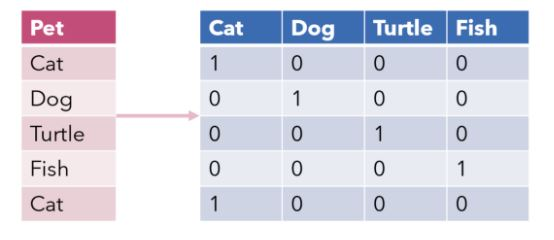

In [69]:
OneHotEncoder().fit_transform(X[["sexo", "ingreso"]])

<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [70]:
OneHotEncoder().fit_transform(X).toarray()

array([[0., 1., 1., 0., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0., 0., 1.]])

In [71]:
X

,sexo,provincia,ingreso
0,M,CABA,medio
1,M,CABA,alto
2,F,PBA,alto
3,F,Córdoba,bajo
4,F,Córdoba,medio


In [72]:
encoder = OneHotEncoder().fit(X)
pd.DataFrame(encoder.transform(X).toarray(), columns=[c for cc in encoder.categories_ for c in cc])

,F,M,CABA,Córdoba,PBA,alto,bajo,medio
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [73]:
pd.DataFrame(encoder.transform(X).toarray(),
            columns=[
                f"{column}_{category}" for categories, column in zip(encoder.categories_, X.columns)
                for category in categories
            ])

,sexo_F,sexo_M,provincia_CABA,provincia_Córdoba,provincia_PBA,ingreso_alto,ingreso_bajo,ingreso_medio
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### C.- Escalado y normalización

En casi todos los algoritmos basados en algebra (regresiones y redes neuronales), los parámetros del modelo se encuentran con alguna variante de `gradient descent` y por tanto adolecen de sensibilidad a la escala de los parámetros. Por ello, es llevar a todas las variables a un rango homogéneo. Esto normalmente se logra con el escalado de cada columna para que estén en el mismo rango o tengan media y desvíos iguales.



In [74]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer

X = pd.DataFrame([
    [1,-200,30000],
    [2, 100, 50000],
    [5,0, 100000]
], columns=[f"c{i}" for i in range(3)])
X

,c0,c1,c2
0,1,-200,30000
1,2,100,50000
2,5,0,100000


Con `StandardScaler` podemos transformar las variables a valores con media 0 y varianza 1

In [75]:
StandardScaler().fit_transform(X)

array([[-0.98058068, -1.33630621, -1.01904933],
       [-0.39223227,  1.06904497, -0.33968311],
       [ 1.37281295,  0.26726124,  1.35873244]])

In [76]:
StandardScaler().fit_transform(X).mean(axis=0).round(10)

array([0., 0., 0.])

In [77]:
StandardScaler().fit_transform(X).std(axis=0)

array([1., 1., 1.])

También podemos escalarlos entre un valor mínimo y máximo, que por default es 0 y 1 usando `MinMaxScaler`

In [78]:
MinMaxScaler().fit_transform(X)

array([[0.        , 0.        , 0.        ],
       [0.25      , 1.        , 0.28571429],
       [1.        , 0.66666667, 1.        ]])

Y con `MaxAbsScaler` podemos escalarlo por el máximo valor absoluto, es decir, haciendo 1 el valor máximo (en términos absolutos)

In [79]:
MaxAbsScaler().fit_transform(X)

array([[ 0.2, -1. ,  0.3],
       [ 0.4,  0.5,  0.5],
       [ 1. ,  0. ,  1. ]])

La normalización es similar pero actúa a nivel fila, y se usa cuando vamos a usar algoritmos que miden distancias entre vectores.


In [80]:
Normalizer().fit_transform(X)

array([[ 3.33325926e-05, -6.66651852e-03,  9.99977778e-01],
       [ 3.99999200e-05,  1.99999600e-03,  9.99997999e-01],
       [ 4.99999999e-05,  0.00000000e+00,  9.99999999e-01]])

In [81]:
X

,c0,c1,c2
0,1,-200,30000
1,2,100,50000
2,5,0,100000


In [82]:
Normalizer().fit_transform(StandardScaler().fit_transform(X))

array([[-0.50397549, -0.68680282, -0.52374669],
       [-0.33007486,  0.89963244, -0.28585322],
       [ 0.70403462,  0.13706249,  0.69681356]])

In [83]:
transformada = Normalizer().fit_transform(StandardScaler().fit_transform(X))
np.square(transformada)

array([[0.25399129, 0.47169811, 0.2743106 ],
       [0.10894942, 0.80933852, 0.08171206],
       [0.49566474, 0.01878613, 0.48554913]])

In [84]:
np.square(transformada).sum(axis=1)

array([1., 1., 1.])

### Creación de Variables (Feature Engineering)

In [85]:
from sklearn.preprocessing import PolynomialFeatures

X = pd.DataFrame([
    [1,-20],
    [2, 10],
    [5,0]
], columns=[f"c{i+1}" for i in range(2)])

print(X)

pd.DataFrame(PolynomialFeatures().fit_transform(X),
             columns=["1", "c1", "c2", "c1^2", "c1*c2", "c2^2"])

   c1  c2
0   1 -20
1   2  10
2   5   0


,1,c1,c2,c1^2,c1*c2,c2^2
0,1.0,1.0,-20.0,1.0,-20.0,400.0
1,1.0,2.0,10.0,4.0,20.0,100.0
2,1.0,5.0,0.0,25.0,0.0,0.0


# Ejercitación

### Leer los datos del Titanic y transformarlos para lograr el mejor valor de la siguiente función.

In [86]:
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

Creamos una función para calcular el resultado de un modelo simple de Regresión Logística

In [87]:
def metric(X):
    X_train, X_test, y_train, y_test = train_test_split(X.drop("Survived", axis=1), X["Survived"],
                                                        test_size=0.25, random_state=42)
    model = LogisticRegressionCV()
    model.fit(X_train, y_train)
    return log_loss(y_test,  model.predict_proba(X_test)), accuracy_score(y_test,  model.predict(X_test)), roc_auc_score(y_test,  model.predict(X_test))

Leemos los Datos

In [88]:
try:
    data = pd.read_csv("../data/titanic.csv", index_col="PassengerId")
except:
    data = pd.read_csv("https://raw.githubusercontent.com/Argentan/DMA_LAB2/master/data/titanic.csv", index_col="PassengerId")

In [89]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Esta es la métrica base, sin hacer nada más que permitir que el modelo corra

In [90]:
metric(data.fillna(99999).drop(data.select_dtypes("O"), axis=1))

(0.6452642098950817, 0.6591928251121076, 0.5956733187992621)

Vemos el resultado de estas métricas si predijeramos todos ceros (nadie sobrevive)

In [91]:
accuracy_score(data["Survived"], np.zeros(data.shape[0]))

0.6161616161616161

In [92]:
roc_auc_score(data["Survived"], np.zeros(data.shape[0]))

0.5

Vemos los Nulos en las Variables

In [93]:
data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Vemos las variables de tipo Categóricas

In [94]:
data.select_dtypes("O")

,Name,Sex,Ticket,Cabin,Embarked
PassengerId,,,,,
1,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
5,"Allen, Mr. William Henry",male,373450,NaN,S
...,...,...,...,...,...
887,"Montvila, Rev. Juozas",male,211536,NaN,S
888,"Graham, Miss. Margaret Edith",female,112053,B42,S
889,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,NaN,S


Otras características a estudiar:

In [95]:
data.Cabin.fillna("NA").value_counts()

NA             687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

In [96]:
data.Cabin.str[0].fillna("NA").value_counts()

NA    687
C      59
B      47
D      33
E      32
A      15
F      13
G       4
T       1
Name: Cabin, dtype: int64

In [97]:
data.Name.str.split(",")

PassengerId
1                             [Braund,  Mr. Owen Harris]
2      [Cumings,  Mrs. John Bradley (Florence Briggs ...
3                              [Heikkinen,  Miss. Laina]
4        [Futrelle,  Mrs. Jacques Heath (Lily May Peel)]
5                            [Allen,  Mr. William Henry]
                             ...                        
887                             [Montvila,  Rev. Juozas]
888                      [Graham,  Miss. Margaret Edith]
889          [Johnston,  Miss. Catherine Helen "Carrie"]
890                             [Behr,  Mr. Karl Howell]
891                               [Dooley,  Mr. Patrick]
Name: Name, Length: 891, dtype: object

In [98]:
data.Name.str.split(",").str[0].value_counts()

Andersson    9
Sage         7
Panula       6
Skoog        6
Carter       6
            ..
Hanna        1
Lewy         1
Mineff       1
Haas         1
Dooley       1
Name: Name, Length: 667, dtype: int64

Consejos adicionales para explorar:
*    Analizar los valores vacios `""`. ¿Se puede asimilar a un Nulo?
*    Analizar los valores cero `0`. ¿Se puede asimilar a un Nulo?
*    ¿Se pueden agrupar pasajeros en grupos? Por ejemplo: Familia
*    A partir de la edad, ¿podemos crear una variable que mejore la separación del modelo?
*    ¿Se puede crear una variable "Madre"?
*    ¿Mejora el modelo si normalizamos las variables continuas?
*    ¿Y si convertimos las variables continuas en rangos fijos?

**Analizar los valores vacios "". ¿Se puede asimilar a un Nulo?**

Los valores vacíos `""` se consideran valores nulos o faltantes. Es decir, cuando una columna tiene valores vacíos, significa que la información no está disponible para esos registros.

Por ejemplo, si en la columna `Cabin` (cabina) se encuentra un valor vacío, esto podría indicar que no se dispone de información sobre la cabina asignada al pasajero.

En otras columnas, los valores vacíos pueden tener diferentes interpretaciones. Por ejemplo, en la columna `Embarked` (puerto de embarque), un valor vacío podría indicar que la información sobre el puerto de embarque no se ha registrado o se ha perdido.

En resumen, los valores vacíos `""` se consideran valores nulos o faltantes, y se deben tratar de manera adecuada durante el análisis de datos y la modelización.

**Analizar los valores cero 0. ¿Se puede asimilar a un Nulo?**

Los valores 0 pueden estar presentes en diferentes columnas y pueden tener diferentes interpretaciones según el contexto.

Por ejemplo, si en la columna `Age` (edad) se encuentra un valor de `0`, esto podría indicar que la edad del pasajero es desconocida o no se ha registrado, y en este caso podría ser asimilado a un valor nulo o faltante.

Por otro lado, si en la columna `SibSp` (número de hermanos/cónyuges a bordo) o Parch (número de padres/hijos a bordo) se encuentra un valor de `0`, esto podría indicar que el pasajero no tiene hermanos/cónyuge o padres/hijos a bordo, y en este caso no se consideraría como un valor nulo o faltante.

En resumen, los valores `0` en el dataset de Titanic pueden tener diferentes interpretaciones según la columna en la que se encuentren, y no necesariamente se pueden asimilar a un valor nulo o faltante. Es importante revisar el contexto de cada columna para determinar el significado de los valores `0`.

**¿Se pueden agrupar pasajeros en grupos? Por ejemplo: Familia**

Para identificar a los pasajeros que podrían pertenecer a una familia, se pueden utilizar diferentes criterios, como el mismo apellido, el mismo número de billete, o el mismo grupo de acompañantes.

Una vez identificados los pasajeros que pertenecen a una misma familia, se pueden utilizar estos grupos en el análisis de datos y en la modelización para obtener mejores resultados y una mejor comprensión de los datos. Por ejemplo, se puede analizar la supervivencia de los miembros de cada familia, o la distribución de las edades y los géneros de los miembros de cada familia.

In [99]:
# Agregar una columna con el apellido de cada pasajero
data['Apellido'] = data['Name'].apply(lambda x: x.split(',')[0])

# Identificar a los pasajeros que tienen el mismo apellido
familias = data.groupby('Apellido').groups

# Imprimir las familias identificadas y sus miembros
i=0
for familia, indices in familias.items():
    print('--------------------- ', familia)
    print(data.loc[indices])
    if (i > 5):
      break
    i += 1

---------------------  Abbing
             Survived  Pclass                 Name   Sex   Age  SibSp  Parch  \
PassengerId                                                                    
846                 0       3  Abbing, Mr. Anthony  male  42.0      0      0   

                Ticket  Fare Cabin Embarked Apellido  
PassengerId                                           
846          C.A. 5547  7.55   NaN        S   Abbing  
---------------------  Abbott
             Survived  Pclass                              Name     Sex   Age  \
PassengerId                                                                     
280                 1       3  Abbott, Mrs. Stanton (Rosa Hunt)  female  35.0   
747                 0       3       Abbott, Mr. Rossmore Edward    male  16.0   

             SibSp  Parch     Ticket   Fare Cabin Embarked Apellido  
PassengerId                                                          
280              1      1  C.A. 2673  20.25   NaN        S   Abbott  

**¿Se puede crear una variable "Madre"?**

Es posible crear una variable "Madre" en el dataset de Titanic. Podríamos intentar inferir quiénes son las madres de cada pasajero utilizando información adicional, como la edad y el número de hijos a bordo. Aunque esta inferencia podría no ser completamente precisa, podría proporcionar una aproximación útil.

Por ejemplo, podríamos definir a una pasajera como "Madre" si cumplió con las siguientes condiciones:

* Era mujer.
* Tenía más de 18 años.
* Tenía al menos un hijo a bordo.

Podríamos crear una nueva columna en el dataset llamada "Madre" y asignar un valor binario (1 o 0) a cada pasajero en función de si cumple o no con estas condiciones. Sin embargo, es importante tener en cuenta que esta variable sería una aproximación y que podría no ser precisa en todos los casos.

A continuación se muestra un ejemplo de cómo se podría crear esta variable en Python utilizando Pandas:

In [100]:
# Crear una variable binaria "Madre"
data['Madre'] = 0

# Si el pasajero tiene una madre a bordo, asignar 1 a la variable "Madre"
data.loc[(data['Sex'] == 'female') & (data['Parch'] > 0) & (data['Age'] > 18), 'Madre'] = 1

data[data["Madre"] == 1].head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Apellido,Madre
PassengerId,,,,,,,,,,,,,
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Johnson,1
26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S,Asplund,1
89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S,Fortune,1
99,1,2,"Doling, Mrs. John T (Ada Julia Bone)",female,34.0,0,1,231919,23.0000,NaN,S,Doling,1
137,1,1,"Newsom, Miss. Helen Monypeny",female,19.0,0,2,11752,26.2833,D47,S,Newsom,1


**¿Mejora el modelo si normalizamos las variables continuas?**

La normalización de variables continuas puede ayudar a mejorar el rendimiento de algunos modelos de aprendizaje automático. La normalización se refiere a la escala de las variables continuas para que tengan un rango común y se puedan comparar de manera efectiva. Por ejemplo, si una variable tiene valores en el rango de 0 a 1 y otra variable tiene valores en el rango de 0 a 1000, el modelo puede darle más peso a la segunda variable, ya que sus valores son mucho más grandes.

Por lo tanto, normalizar las variables continuas puede ayudar a evitar que el modelo esté sesgado hacia las variables que tienen valores más grandes. Además, algunos algoritmos de aprendizaje automático, como las redes neuronales, requieren que las variables estén normalizadas para funcionar de manera óptima.

Sin embargo, es importante tener en cuenta que no todos los modelos de aprendizaje automático se benefician de la normalización y que la normalización también puede afectar la interpretación de las variables en algunos casos. Por lo tanto, la normalización debe realizarse cuidadosamente y en función de las características específicas del conjunto de datos y del modelo utilizado.

**¿Y si convertimos las variables continuas en rangos fijos?**

Convertir las variables continuas en rangos fijos se conoce como "discretización" o "binning". Es una técnica que puede ser útil en algunos casos, especialmente cuando hay patrones no lineales o no monotónicos en los datos, o cuando se tiene una cantidad limitada de datos.

Sin embargo, discretizar las variables continuas también puede tener algunas desventajas. Primero, puede haber una pérdida de información y precisión al agrupar los datos en rangos fijos. En segundo lugar, el número de intervalos o "bins" seleccionados puede tener un impacto significativo en el rendimiento del modelo, y no hay una forma única de seleccionar el número óptimo de bins. Además, la discretización también puede introducir ruido o errores en los datos, especialmente si los límites de los intervalos no se seleccionan cuidadosamente.

Una variable que podría discretizarse en el dataset de Titanic es la edad de los pasajeros. Por ejemplo, se podría crear una nueva variable llamada "GrupoEdad" que divida a los pasajeros en diferentes grupos de edad, como "niños", "jóvenes", "adultos" y "ancianos".

In [101]:
# Crear una nueva columna llamada "GrupoEdad" basada en la columna "Age"
bins = [0, 12, 25, 60, 120] # definir los intervalos para cada grupo de edad
labels = ['niños', 'jóvenes', 'adultos', 'ancianos'] # definir los nombres de cada grupo de edad
data['GrupoEdad'] = pd.cut(data['Age'], bins=bins, labels=labels)

# Mostrar los primeros registros del conjunto de datos con la nueva columna "GrupoEdad"
print(data.head())

             Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  \
PassengerId                                                           
1                1      0         A/5 21171   7.2500   NaN       

Realizar todos los pre-procesamientos posibles y ver cuánto se puede llegar a mejorar las métricas para un modelo simple.